<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Experiments/Embedding_As_Feature/distilBERT_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tokenizers datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

In [3]:
import datasets

data = datasets.load_dataset("raygx/NepCov19TweetsPlus").rename_columns({"Sentiment":"label","Sentences":"text"}).shuffle(999)['train'].train_test_split(test_size=0.2)
data


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/41541 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [4]:
def LabelEncoding(x):
    if x['label']==-1:
        x['label'] =  2
    return x

data = data.map(
        LabelEncoding,
        num_proc=2)

data['train'][:5]

Map (num_proc=2):   0%|          | 0/33232 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/8309 [00:00<?, ? examples/s]

{'label': [0, 0, 0, 0, 1],
 'text': ['बालबालिकामा कोभिड का लक्षण देखिएमा के गर्ने सफल नेपाल',
  'कोविड र सामान्य चिसोमा के गर्ने र नगर्ने बीच कसरी फरक गर्ने',
  'बैठकमा मिलेनियम च्यालेन्ज कर्पोरेशन एमसीसीको बजेट र कोभिडबारे पनि छलफल हुने अर्का स्थायी समिति सदस्य देवेन्द्र पौडेलले जानकारी दिए ।',
  'कोभिड –१९ महामारीले नेपालमा बालबालिकाको स्वास्थ्य, सिकाइ र मनोसामाजिक अवस्थालाई असर पारेको\u200d युनिसेफकाे एक अध्ययनले देखाएको छ\xa0। \u200d',
  'डब्लूएचओको प्रत्यक्ष निगरानीमा कोरोना परीक्षण कोभिड यसकारण भित्रिएको छैन नेपालमा']}

In [18]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel

model_id = 'raygx/distilBERT-NepSA' ##'raygx/BERT-NepSA-T2' ## Fine-tuned Model for SA ## 'raygx/BertClassifier4NepaliNews' ## Fine-tuned Model for NewsClassification ## 'Shushant/nepaliBERT' ## Pre-Trained LM ##

bertTokenizer = PreTrainedTokenizerFast.from_pretrained(model_id)
try:
  bertModel = TFAutoModel.from_pretrained(model_id)
except:
  bertModel = TFAutoModel.from_pretrained(model_id,from_pt=True)

bertModel.summary()
print(bertModel.config)

Some layers from the model checkpoint at raygx/distilBERT-NepSA were not used when initializing TFDistilBertModel: ['pre_classifier', 'dropout_39', 'classifier']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at raygx/distilBERT-NepSA.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 81321984  
 nLayer)                                                         
                                                                 
Total params: 81,321,984
Trainable params: 81,321,984
Non-trainable params: 0
_________________________________________________________________
DistilBertConfig {
  "_name_or_path": "raygx/distilBERT-NepSA",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "dim": 768,
  "dropout": 0.1,
  "eos_token_id": 2,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings"

### Code For Using BERT as Embedding Layer

In [19]:
import tensorflow as tf

class dBERTEmbedding(tf.keras.layers.Layer):
    def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
        super().__init__()
        self.embedding = model
        self.tokenizer = tokenizer
        self.max_token = max_token_len
        self.padding = padding
        self.truncation = truncation
        self.trainable=False

    def call(self, x):
        x = self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))
        return x['last_hidden_state'][:,0,:]

In [26]:
# model.bert(tokenizer('बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको',padding='max_length',truncation=True,return_tensors='tf',max_length=128))
embd = dBERTEmbedding(bertModel,bertTokenizer,max_token_len=100)
# embd(["",'बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको','बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको'])
# embd(["abcd"])
d_model = embd(["abcd",'efgh'])
print(d_model)
d_model = d_model.shape[1]

tf.Tensor(
[[ 0.59106755 -0.45176938  0.62758726 ... -0.40321526 -1.0253834
   0.39130825]
 [ 0.5563907  -0.48318365  0.42689878 ... -0.3517984  -1.0502453
   0.658915  ]], shape=(2, 768), dtype=float32)


In [27]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data,model_dim, batch_size=32,shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.data = data
        self.embeddings = np.empty((data.num_rows,model_dim))
        self.shuffle = shuffle
        # self.average = tf.keras.layers.Average()
        self.is_first_epoch = True
        self.on_epoch_end(is_first_epoch=self.is_first_epoch)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.data.num_rows / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)

    def on_epoch_end(self,is_first_epoch=False):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.data.num_rows)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        self.is_first_epoch = is_first_epoch


    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        chunk = self.data.select(indexes)

        if self.is_first_epoch:
          X = embd(chunk['text'])
          self.embeddings[indexes] = X
        else:
          X = self.embeddings[indexes]

        y = np.array(chunk['label'])
        return X,y

In [28]:
%%time

train_features = DataGenerator(data['train'],model_dim=d_model,batch_size=16)
test_features = DataGenerator(data['test'],model_dim=d_model,shuffle=False)

CPU times: user 1.87 ms, sys: 0 ns, total: 1.87 ms
Wall time: 1.89 ms


## Model Specification

In [29]:
sa_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(768)),
    tf.keras.layers.Dense(768,activation='relu',name='Dense'),
    tf.keras.layers.Dropout(0.1,name='Dropout'),
    tf.keras.layers.Dense(3,activation='softmax',name='Activation')
])

In [30]:
sa_model.compile(
  optimizer=tf.keras.optimizers.Adam(
        learning_rate=5e-4,
        weight_decay=0.001
      ),
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

sa_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense (Dense)               (None, 768)               590592    
                                                                 
 Dropout (Dropout)           (None, 768)               0         
                                                                 
 Activation (Dense)          (None, 3)                 2307      
                                                                 
Total params: 592,899
Trainable params: 592,899
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = sa_model.fit(train_features,
        epochs=30,
        validation_data=test_features,
        callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_acc', patience=3,
                            verbose=1, mode='max',
                            restore_best_weights=True)
                        ])

Epoch 1/30
2077/2077 [==============================] - 285s 137ms/step - loss: 0.4087 - acc: 0.8425 - val_loss: 0.4022 - val_acc: 0.8447
Epoch 2/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.3901 - acc: 0.8479 - val_loss: 0.3977 - val_acc: 0.8447
Epoch 3/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.3826 - acc: 0.8518 - val_loss: 0.3947 - val_acc: 0.8487
Epoch 4/30
2077/2077 [==============================] - 13s 6ms/step - loss: 0.3728 - acc: 0.8555 - val_loss: 0.3940 - val_acc: 0.8466
Epoch 5/30
2077/2077 [==============================] - 13s 6ms/step - loss: 0.3629 - acc: 0.8603 - val_loss: 0.3985 - val_acc: 0.8463
Epoch 6/30
2077/2077 [==============================] - 13s 6ms/step - loss: 0.3520 - acc: 0.8645 - val_loss: 0.3993 - val_acc: 0.8484
Epoch 6: early stopping


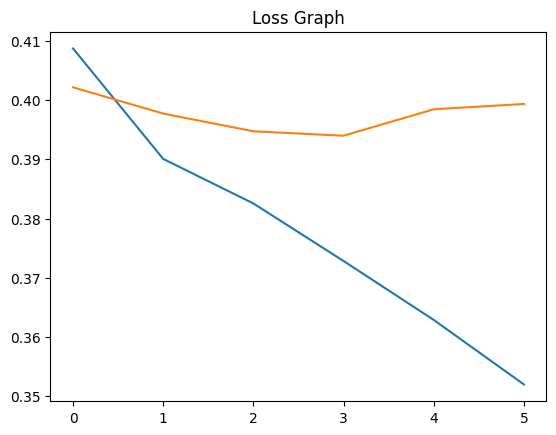

Text(0.5, 1.0, 'Accuracy Graph')

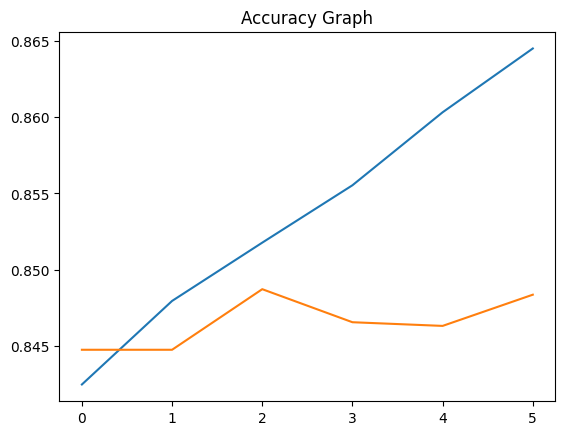

In [32]:
import seaborn
from matplotlib import pyplot as plt

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])
plt.title("Loss Graph")
plt.show()

seaborn.lineplot(history.history['acc'])
seaborn.lineplot(history.history['val_acc'])
plt.title("Accuracy Graph")

## Evaluation Section

In [33]:
%%time

print("Getting Test Prediction")
pred_labels = [np.argmax(x) for x in sa_model.predict(test_features)]
actual_labels = data['test']['label']

Getting Test Prediction
260/260 [==============================] - 1s 5ms/step
CPU times: user 1.39 s, sys: 85.4 ms, total: 1.48 s
Wall time: 1.63 s


In [34]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.8488354987837109
Precision-Score 0.8497241201240066
Recall-Score 0.8487182573113491
accuracy_Score 0.8487182573113491


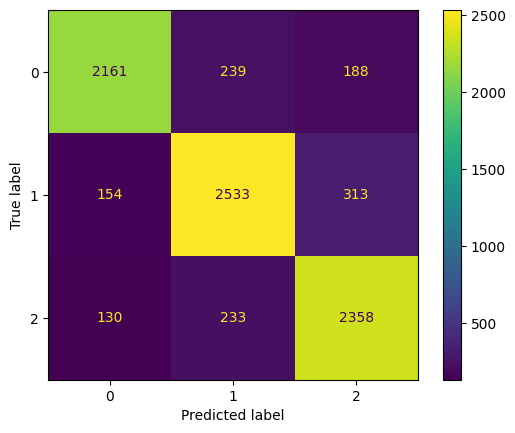

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()